In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import sys
import time

tfd = tfp.distributions
tfb = tfp.bijectors
tfkl=keras.layers
tfk=tf.keras

import matplotlib.pyplot as plt
import numpy as np


#path to shared tensorflow dataset
eagle_dir='/scratch/mhuertas/tensorflow_datasets/eagle'

Load Dataset

In [2]:
from sfh.datasets.eagle import eagle

dset_eagle = tfds.load('eagle', split='train', data_dir=eagle_dir)

2022-05-04 10:54:51.561949: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-04 10:54:53.964151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1041 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-05-04 10:54:53.964897: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9334 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-05-04 10:54:53.965466: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/repli

Visualize:

You remove nans with ind valid, but just in some columns

wl_sort are frequencies



Train 7314
<TakeDataset element_spec={'Mstar': TensorSpec(shape=(100,), dtype=tf.float32, name=None), 'SFR_Max': TensorSpec(shape=(100,), dtype=tf.float32, name=None), 'inds_valid': TensorSpec(shape=(143,), dtype=tf.bool, name=None), 'mass_quantiles': TensorSpec(shape=(9,), dtype=tf.float32, name=None), 'object_id': TensorSpec(shape=(), dtype=tf.int32, name=None), 'sed': TensorSpec(shape=(125,), dtype=tf.float32, name=None), 'time': TensorSpec(shape=(100,), dtype=tf.float32, name=None), 'wl_sort': TensorSpec(shape=(143,), dtype=tf.float32, name=None)}>


2022-05-04 10:54:55.909641: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


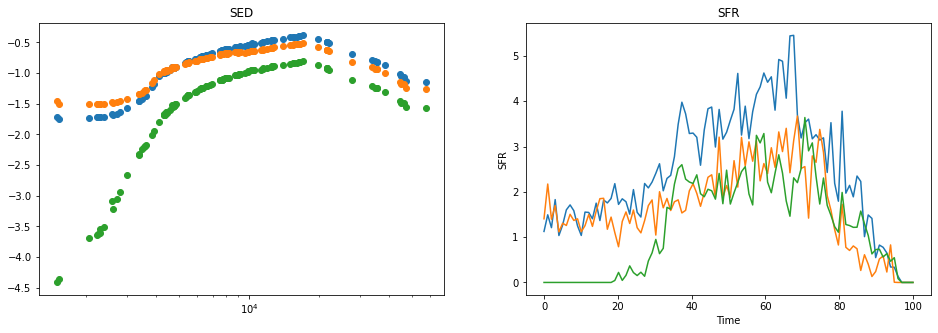

In [3]:
print("Train",len(dset_eagle))

example=dset_eagle.take(1)
print(example)

fig, axs = plt.subplots(1, 2,figsize=(16,5))
for example in dset_eagle.take(3):
    inds_valid = example['inds_valid']
    axs[0].scatter((example['wl_sort'])[example['inds_valid']],np.log10(example['sed']))
    axs[0].set_xscale('log')
    axs[0].set_title('SED')
    axs[1].plot(example['time'],example['SFR_Max'])
    axs[1].set_title('SFR')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('SFR')
    



Preprocessing, include normalization, deal with NANs

In [4]:
def preprocessing(example):
    mass = example['mass_quantiles'][:,0]
    return tf.reshape(example['sed'],(-1,125,1)), \
           tf.reshape(example['mass'],(-1,100,1))

def preprocessing_wmass(example):
    mass = example['Mstar'][:,0]
    mass_half = example['Mstar_Half'][:,0]
    tiler = tf.constant([100])
    mass = tf.reshape(tf.tile(mass, tiler),(-1,100,1))
    mass_half = tf.reshape(tf.tile(mass_half, tiler),(-1,100,1))
    sfr = tf.math.add(tf.reshape(example['SFR_Max'],(-1,100,1)), 1e-5)
    res = tf.concat([sfr, mass, mass_half], axis=2)
    return res, res

def preprocessing_wmass_atan(example):
    mass = example['Mstar'][:,0]
    #mass_half = example['Mstar_Half'][:,0]
    #sed = (tf.gather(example['sed'],inds, axis=1) + 20.70243)/2.0466275
    sed = example['sed']
    tiler = tf.constant([100])
    mass = tf.reshape(tf.tile(mass, tiler),(-1,100,1))
    #mass_half = tf.reshape(tf.tile(mass_half, tiler),(-1,100,1))
    sfr = tf.math.tanh(tf.math.asinh(tf.reshape(example['SFR_Max'],(-1,100,1))/40) + 1e-3 + 0.005*tf.math.softplus(tf.random.normal(shape=[64,100,1])))
    res = tf.concat([sfr], axis=2) #  mass, mass_half
    return (res, sed), res

def input_fn(mode='train', batch_size=64, 
             dataset_name='eagle', data_dir=None,
             include_mass=True, arctan=True):
    """
    mode: 'train' or 'test'
    """
    keys = ['sed','Mstar', 'SFR_Max', 'mass_quantiles', 'sed', 'time']
    if mode == 'train':
        dataset = tfds.load(dataset_name, split='train[:90%]', data_dir=data_dir)
        dataset = dataset.map(lambda x: {k:x[k] for k in keys})
        dataset = dataset.repeat()
        dataset = dataset.shuffle(10000)
    else:
        dataset = tfds.load(dataset_name, split='train[90%:]', data_dir=data_dir)
        dataset = dataset.map(lambda x: {k:x[k] for k in keys}) #dataset = dataset.repeat()
        
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if include_mass and arctan:
        dataset = dataset.map(preprocessing_wmass_atan) # Apply data preprocessing
    elif include_mass:
        dataset = dataset.map(preprocessing_wmass)
    else : 
        dataset = dataset.map(preprocessing)
        
    dataset = dataset.prefetch(-1)       # fetch next batches while training current one (-1 for autotune)
    return dataset

Prepare your training and validation dataset

In [5]:
batch_size = 64
epochs = 10

dtrain_eagle = input_fn(mode='train', batch_size=batch_size, dataset_name='eagle',data_dir=eagle_dir)
dval_eagle = input_fn(mode='val', batch_size=batch_size, dataset_name='eagle',data_dir=eagle_dir)

Generating regression model (CNN)

In [6]:


def generate_model(n_timesteps,n_filters):
    """Generate the regression Keras model"""
    #Parameters
    #----------
    """
    
    n_timesteps : int
        Number of time steps.
    n_filters : int
        Number of filters.
    n_channels : int, default 1
        Number of channels in the dataset
    n_components : int, default 2
        Number of components in the Gaussian mixture distribution.
    kernel_size : int, default 3
        Size of the convolution kernel.

    Returns
    -------
    Keras model

    """
    input_sfh = keras.layers.Input(shape=(n_timesteps,1))
    input_sed = keras.layers.Input(shape=(n_filters,1))
    
    regression_cnn = tfk.Sequential([
    tf.keras.layers.Flatten(input_shape=(1,1)),      
    tfkl.Dense(10, activation='sigmoid'),
    tfkl.Dense(1, activation=None)])
    
    regression_cnn.compile(optimizer=tf.optimizers.Adam(),loss='mse')
    regression_cnn.fit(input_sed,input_sfh,batch_size=1,epochs=100)
    

    return regression_cnn

In [12]:
regression_cnn = generate_model(100,100)
regression_cnn.summary()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

Fit your model with EAGLE data

In [ ]:
hist = regression_cnn.fit(dtrain_eagle, 
                     epochs=epochs,
                     steps_per_epoch=1000,validation_data=dval_eagle)

Test with EAGLE data

In [ ]:
dset_test = dval_eagle.as_numpy_iterator()
data = next(dset_test)
ind=55
sample = np.zeros([64,100,1])
true = data[0][0][ind,:,0]
sed = data[0][1][ind].reshape([1,125,1]).repeat(64,axis=0)

# init at the 
sample[:,0,0] = true[0]

for i in range(99):
    tmp = eagle_cnn((sample, sed)).sample()
    sample[:,i+1,0] = tmp[:,i+1]

plt.plot(true,label='true SFH')
for i in range(64):
    plt.plot(sample[i,:,0],color='C1',alpha=0.1)
plt.plot(sample[1,:,0],color='C1',alpha=1.,label='individual sample')    
plt.plot(sample.mean(axis=0)[:,0],'--',color='red',label='mean posterior')
plt.legend(loc='upper left')


